<a href="https://colab.research.google.com/github/bebechien/gemma/blob/main/How_to_Fine_tuning_Gemma_Random_Korean_Movie_Titles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2024 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# How to Fine-tuning Gemma: Best Practices

To illustrate fine-tuning the model for a specific task, let's consider the example of generating a random Korean title based on a user's instruction such as "Write a title". To make this possible, we curated a manageable dataset that could be manually processed. This approach is feasible because Gemma 2 has prior knowledge of general Korean language patterns, enabling it to adapt to this specific task effectively.

## Setup

### Select the Colab runtime
To complete this tutorial, you'll need to have a Colab runtime with sufficient resources to run the Gemma model:

1. In the upper-right of the Colab window, select **▾ (Additional connection options)**.
2. Select **Change runtime type**.
3. Under **Hardware accelerator**, select **T4 GPU**.


### Gemma setup on Kaggle
To complete this tutorial, you'll first need to complete the setup instructions at [Gemma setup](https://ai.google.dev/gemma/docs/setup). The Gemma setup instructions show you how to do the following:

* Get access to Gemma on kaggle.com.
* Select a Colab runtime with sufficient resources to run the Gemma 2B model.
* Generate and configure a Kaggle username and API key.

After you've completed the Gemma setup, move on to the next section, where you'll set environment variables for your Colab environment.

### Set environemnt variables

Set environement variables for ```KAGGLE_USERNAME``` and ```KAGGLE_KEY```.

In [1]:
import os
from google.colab import userdata, drive

# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate for your system.
os.environ["KAGGLE_USERNAME"] = userdata.get("KAGGLE_USERNAME")
os.environ["KAGGLE_KEY"] = userdata.get("KAGGLE_KEY")

# Mounting gDrive for to store artifacts
#drive.mount("/content/drive")

### Install dependencies

Install Keras and KerasNLP

In [2]:
!pip install -q -U keras-nlp datasets
!pip install -q -U keras

# Set the backbend before importing Keras
os.environ["KERAS_BACKEND"] = "jax"
# Avoid memory fragmentation on JAX backend.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"

import keras_nlp
import keras

# Run at half precision.
#keras.config.set_floatx("bfloat16")

# Training Configurations
token_limit = 128
num_data_limit = 100
lora_name = "my_lora"
lora_rank = 4
lr_value = 1e-3
train_epoch = 5
model_id = "gemma2_instruct_2b_en"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.1/548.1 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.4 MB/s e

## Load Model

In [3]:
import keras
import keras_nlp

import time

gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset(model_id)
gemma_lm.summary()

tick_start = 0

def tick():
    global tick_start
    tick_start = time.time()

def tock():
    print(f"TOTAL TIME ELAPSED: {time.time() - tick_start:.2f}s")

def text_gen(prompt):
    tick()
    input = f"<start_of_turn>user\n{prompt}<end_of_turn>\n<start_of_turn>model\n"
    output = gemma_lm.generate(input, max_length=token_limit)
    print("\nGemma output:")
    print(output)
    tock()

# inference before fine-tuning
text_gen("Translate the text below to Japanese.\n\"Hi, how can I get to the Tokyo museum?\"")
text_gen("Speak like a pirate. Teach me why the earth is flat.")
text_gen("Write a title")
text_gen("Write a poem")


Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,614,341,888 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,614,341,888 (9.74 GB)

 Trainable params: 2,614,341,888 (9.74 GB)

 Non-trainable params: 0 (0.00 B)


Gemma output:
<start_of_turn>user
Translate the text below to Japanese.
"Hi, how can I get to the Tokyo museum?"<end_of_turn>
<start_of_turn>model
こんにちは、東京博物館はどこへ行くのが良いですか？ 

Here's a breakdown:

* **こんにちは** - Hello
* **どこへ行くのが良いですか** -  What's the best way to get there? (formal)
* **東京博物館** - Tokyo Museum


Let me know if you'd like me to translate any other phrases! 
<end_of_turn>
TOTAL TIME ELAPSED: 21.07s

Gemma output:
<start_of_turn>user
Speak like a pirate. Teach me why the earth is flat.<end_of_turn>
<start_of_turn>model
Ahoy, matey! Ye be wantin' to know 'bout the Earth, eh? Shiver me timbers, ye be lookin' at a tale spun by landlubbers! 

The Earth be no flat sheet o' parchment, but a grand ol' sphere, like a giant, bountiful treasure chest! 

Here's why ye can't be fooled by the scurvy tales:

* **The horizon be a curve, not a straight line:**  When ye look out to sea,
TOTAL TIME ELAPSED: 5.55s

Gemma output:
<start_of_turn>user
Write a title<end_of_turn>
<start_of_turn>mod

## Tokenizer designed with multilingual in mind

In [7]:
tokenizer = keras_nlp.models.GemmaTokenizer.from_preset(model_id)
import jax

def detoken(tokens):
  print(tokens)
  for x in tokens:
    word = tokenizer.detokenize(jax.numpy.array([x]))
    print(f"{x:6} -> {word}")

detoken(tokenizer("안녕하세요. 반갑습니다. 오늘은 날씨가 참 좋네요."))

[238179 243415 204551 235265  78821 241772  21743 235265  44245 240703
 236648 128856 241215 236361 120816 106509 239156 237526 235265]
238179 -> 안
243415 -> 녕
204551 -> 하세요
235265 -> .
 78821 ->  반
241772 -> 갑
 21743 -> 습니다
235265 -> .
 44245 ->  오
240703 -> 늘
236648 -> 은
128856 ->  날
241215 -> 씨
236361 -> 가
120816 ->  참
106509 ->  좋
239156 -> 네
237526 -> 요
235265 -> .


## Load Dataset

In [4]:
tokenizer = keras_nlp.models.GemmaTokenizer.from_preset(model_id)

# example titles
data = [
    "푸른 달 아래의 왈츠",
    "잃어버린 도시의 속삭임",
    "별빛 아래의 춤",
    "꿈꾸는 자들의 도시",
    "시간을 멈추는 시계",
    "그림자 없는 남자",
    "붉은 장미의 비밀",
    "바람이 머무는 곳",
    "마법의 거울 속으로",
    "잊혀진 노래의 선율",
    "밤하늘을 나는 고래",
    "비밀의 숲 속 오두막",
    "영혼의 빛",
    "마지막 잎새의 소원",
    "꿈꾸는 자들의 낙원",
]

train = []

for x in data:
  item = f"<start_of_turn>user\nWrite a title<end_of_turn>\n<start_of_turn>model\n{x}<end_of_turn>"
  length = len(tokenizer(item))
  # skip data if the token length is longer than our limit
  if length < token_limit:
    train.append(item)
    if(len(train)>=num_data_limit):
      break

print(len(train))
print(train[0])
print(train[1])
print(train[2])

15
<start_of_turn>user
Write a title<end_of_turn>
<start_of_turn>model
푸른 달 아래의 왈츠<end_of_turn>
<start_of_turn>user
Write a title<end_of_turn>
<start_of_turn>model
잃어버린 도시의 속삭임<end_of_turn>
<start_of_turn>user
Write a title<end_of_turn>
<start_of_turn>model
별빛 아래의 춤<end_of_turn>


## LoRA Fine-tuning

In [ ]:
# Enable LoRA for the model and set the LoRA rank to 4.
gemma_lm.backbone.enable_lora(rank=lora_rank)
gemma_lm.summary()

# Limit the input sequence length (to control memory usage).
gemma_lm.preprocessor.sequence_length = token_limit
# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=lr_value,
    weight_decay=0.01,
)
# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)


Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                   │                                             256,000 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,617,270,528 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,617,270,528 (9.75 GB)

 Trainable params: 2,928,640 (11.17 MB)

 Non-trainable params: 2,614,341,888 (9.74 GB)

Note that enabling LoRA reduces the number of trainable parameters significantly.

Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 1.4729 - sparse_categorical_accuracy: 0.2734
Gemma output:
<start_of_turn>user
Write a title<end_of_turn>
<start_of_turn>model
<end_of_turn>
TOTAL TIME ELAPSED: 15.49s

Gemma output:
<start_of_turn>user
Write a poem<end_of_turn>
<start_of_turn>model
The wind whispers secrets through the trees,
A rustling symphony, carried on the breeze.
Sunlight dances, dappled and bright,
Painting shadows in the fading light.

A lone bird sings, a melody so clear,
A song of hope, dispelling all fear.
The world unfolds, a canvas vast,
Where dreams take flight, and moments last.

The earth breathes deep, a gentle sigh,
As clouds drift by, across the sky.
A moment caught, in time's embrace,
A fleeting beauty, in this sacred space
TOTAL TIME ELAPSED: 7.90s
8/8 ━━━━━━━━━━━━━━━━━━━━ 128s 12s/step - loss: 1.4512 - sparse_categorical_accuracy: 0.2760
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.6408 - sparse_categorical_accuracy: 0.5438   
Gemma

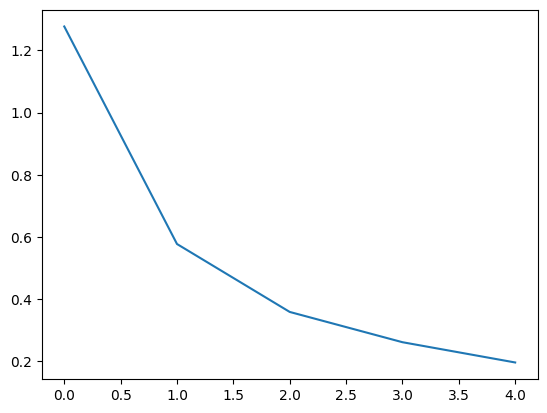

In [ ]:
class CustomCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    #model_name = f"/content/drive/MyDrive/{lora_name}_{lora_rank}_epoch{epoch+1}.lora.h5"
    #gemma_lm.backbone.save_lora_weights(model_name)

    # Evaluate
    text_gen("Write a title")
    text_gen("Write a poem")

history = gemma_lm.fit(train, epochs=train_epoch, batch_size=2, callbacks=[CustomCallback()])

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.show()

## Load LoRA

In [ ]:
#gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset(model_id)
# Use the same LoRA rank that you trained
#gemma_lm.backbone.enable_lora(rank=4)

# Load pre-trained LoRA weights
#gemma_lm.backbone.load_lora_weights(f"/content/drive/MyDrive/{lora_name}_{lora_rank}_epoch{train_epoch}.lora.h5")

## Try a different sampler

The top-K algorithm randomly picks the next token from the tokens of top K probability.

In [ ]:
gemma_lm.compile(sampler="top_k")
text_gen("Write a title")
text_gen("Write a title")
text_gen("Write a title")
text_gen("Write a title")
text_gen("Write a title")


Gemma output:
<start_of_turn>user
Write a title<end_of_turn>
<start_of_turn>model
바람이 피어나는 밤<end_of_turn>
TOTAL TIME ELAPSED: 16.87s

Gemma output:
<start_of_turn>user
Write a title<end_of_turn>
<start_of_turn>model
꿈꾸는 자들의 낙원<end_of_turn>
TOTAL TIME ELAPSED: 0.88s

Gemma output:
<start_of_turn>user
Write a title<end_of_turn>
<start_of_turn>model
바람은 멈추지 않는다<end_of_turn>
TOTAL TIME ELAPSED: 0.95s

Gemma output:
<start_of_turn>user
Write a title<end_of_turn>
<start_of_turn>model
마법의 숲 속 은빛 요정<end_of_turn>
TOTAL TIME ELAPSED: 1.00s

Gemma output:
<start_of_turn>user
Write a title<end_of_turn>
<start_of_turn>model
바람이 머무는 자리<end_of_turn>
TOTAL TIME ELAPSED: 0.87s


Try a slight different prompts

In [ ]:
text_gen("Write a music title")
text_gen("Write a poem title")
text_gen("Write a blog title")
text_gen("Write a movie title")
text_gen("Write a novel title")


Gemma output:
<start_of_turn>user
Write a music title<end_of_turn>
<start_of_turn>model
비밀스러운 울음소리<end_of_turn>
TOTAL TIME ELAPSED: 1.01s

Gemma output:
<start_of_turn>user
Write a poem title<end_of_turn>
<start_of_turn>model
비밀의 숲 속 요정<end_of_turn>
TOTAL TIME ELAPSED: 0.87s

Gemma output:
<start_of_turn>user
Write a blog title<end_of_turn>
<start_of_turn>model
꿈꾸는 자들의 낙원<end_of_turn>
TOTAL TIME ELAPSED: 0.87s

Gemma output:
<start_of_turn>user
Write a movie title<end_of_turn>
<start_of_turn>model
잊혀진 도시 속의 마법 잃어버린 보물<end_of_turn>
TOTAL TIME ELAPSED: 1.35s

Gemma output:
<start_of_turn>user
Write a novel title<end_of_turn>
<start_of_turn>model
비밀의 숲 속 낙원<end_of_turn>
TOTAL TIME ELAPSED: 0.94s
